## Daily Challenge: W6_D5

### Text summarization using NLP

**Introduction**

This notebook demonstrates a practical application of Natural Language Processing (NLP) techniques to automatically generate summaries of text documents. We will explore how to preprocess text data, represent words and sentences as vectors, and leverage graph-based algorithms to identify the most important sentences for summarization.

**What You’ll Learn**

- Text Preprocessing: Techniques for cleaning and preparing text data, including tokenization, stop word removal, and converting text to lowercase.  
- Word Embeddings: Understanding and using pre-trained word embeddings like GloVe to represent words as dense vectors.  
- Sentence Vectorization: Creating vector representations of sentences by aggregating word embeddings.  
- Similarity Measures: Using cosine similarity to determine the semantic similarity between sentences.  
- Graph-Based Summarization: Applying the PageRank algorithm on a graph of sentence similarities to rank sentence importance.  
- Text Summarization Implementation: Combining these techniques to build a text summarization system.

**What You Will Create**

You will create an automatic text summarization system that can take a collection of tennis articles as input and generate a concise summary highlighting the key information.

**Task**

1. **Data Loading and Inspection**  
   Load the tennis articles dataset from the *.xls* file using pandas.  
   Explore the dataset using *.head()* and *.info()* to understand its structure.  
   Drop the *article_title* column to simplify the dataset.

2. **Sentence Tokenization**  
   Use *nltk.sent_tokenize()* to split the *article_text* into individual sentences.  
   Flatten the resulting list of sentence lists into a single list of all sentences.

3. **Download and Load GloVe Word Embeddings**  
   Download the pre-trained GloVe vectors (e.g., *glove.6B.100d.txt*).  
   Load the embeddings into a Python dictionary where each word maps to its 100-dimensional vector.

4. **Text Cleaning and Normalization**  
   Remove punctuation, special characters, and numbers using regex.  
   Convert all sentences to lowercase to avoid case-sensitive mismatch.  
   Remove stop words using *nltk.corpus.stopwords* to reduce noise in the data.

5. **Sentence Vectorization**  
   For each cleaned sentence:  
   - Split into words.  
   - Replace each word with its GloVe vector (use a zero-vector if the word is not in the embedding).  
   - Compute the average of all word vectors in the sentence.  
   Store all resulting sentence vectors in a list.

6. **Similarity Matrix Construction**  
   Initialize an empty matrix of size (number of sentences × number of sentences).  
   Compute pairwise cosine similarity between sentence vectors.  
   Fill in the matrix such that each cell represents the similarity between two sentences.

7. **Graph Construction and Sentence Ranking**  
   Convert the similarity matrix into a graph using *networkx*.  
   Apply the PageRank algorithm to score the importance of each sentence.

8. **Summarization**  
   Sort all sentences based on their PageRank scores in descending order.  
   Extract the top N sentences (e.g., 10) as the final summary.  
   Print or return the summarized sentences.

### Step 1: Data Loading and Inspection

In [21]:
import pandas as pd
import nltk
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [10]:
# Load the dataset from the CSV file using appropriate encoding
df = pd.read_csv("tennis_articles.csv", encoding="ISO-8859-1")

# Display the first few rows to understand the structure
print("First 5 rows of the dataset:")
print(df.head())

# Display the dataset's structure and column types
print("\nDataset info:")
print(df.info())

# Drop the article_title column as it's not needed for summarization
df = df.drop(columns=["article_title"])

First 5 rows of the dataset:
   article_id                                      article_title  \
0           1  I do not have friends in tennis, says Maria Sh...   
1           2  Federer defeats Medvedev to advance to 14th Sw...   
2           3  Tennis: Roger Federer ignored deadline set by ...   
3           4  Nishikori to face off against Anderson in Vien...   
4           5  Roger Federer has made this huge change to ten...   

                                        article_text  \
0  Maria Sharapova has basically no friends as te...   
1  BASEL, Switzerland (AP)  Roger Federer advanc...   
2  Roger Federer has revealed that organisers of ...   
3  Kei Nishikori will try to end his long losing ...   
4  Federer, 37, first broke through on tour over ...   

                                              source  
0  https://www.tennisworldusa.org/tennis/news/Mar...  
1  http://www.tennis.com/pro-game/2018/10/copil-s...  
2  https://scroll.in/field/899938/tennis-roger-fe...  
3  ht

### Step 2: Sentence Tokenization

In [11]:
# Download the punkt tokenizer model if not already present
nltk.download("punkt")

# Tokenize each article into sentences
sentence_lists = df["article_text"].apply(sent_tokenize)

# Flatten the list of lists into a single list of all sentences
sentences = [sentence for article in sentence_lists for sentence in article]

# Display the number of sentences and a preview
print(f"Total number of sentences: {len(sentences)}")
print("First 5 sentences:")
for sent in sentences[:5]:
    print("-", sent)

Total number of sentences: 130
First 5 sentences:
- Maria Sharapova has basically no friends as tennis players on the WTA Tour.
- The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much.
- I think everyone knows this is my job here.
- When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.
- So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


We started by loading a dataset of tennis-related articles from a CSV file using pandas. The dataset contained article IDs, titles, full texts, and source URLs. To simplify our processing, we dropped the article_title column and focused on the article_text column, which holds the full content we want to summarize.

Next, we used nltk.sent_tokenize() to break each article into individual sentences. This step is essential because the summarization algorithm works by selecting the most relevant sentences. After flattening all articles into a single list, we obtained 130 sentences in total, which will serve as the base for our summarization pipeline.

This step ensures that our data is in a sentence-level format suitable for further processing, such as vectorization and similarity computation.

### Step 3: Load GloVe Word Embeddings

In [13]:
# Path to the GloVe file (update the path if it's in a different folder)
glove_path = "glove.6B.100d.txt"

# Create an empty dictionary to hold word:vector mappings
word_embeddings = {}

# Open the GloVe file and read line by line
with open(glove_path, "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = vector

# Check how many words were loaded
print(f"Number of words loaded: {len(word_embeddings)}")

Number of words loaded: 400000


**GloVe Embeddings Loaded**

We successfully loaded 400,000 word vectors from the glove.6B.100d.txt file. Each word is now associated with a 100-dimensional dense vector that captures its semantic meaning. These embeddings will be used to represent sentences numerically in later steps, allowing us to measure similarity and importance between them.

### Step 4: Text Cleaning and Normalization

In [16]:
# Load the English stop words (assumes they are already downloaded)
stop_words = set(stopwords.words("english"))

# Define a function to clean and normalize a sentence
def clean_sentence(sentence):
    # Remove special characters, numbers, and punctuation
    sentence = re.sub(r"[^a-zA-Z]", " ", sentence)
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove stop words and strip extra spaces
    cleaned = " ".join([word for word in sentence.split() if word not in stop_words])
    return cleaned

# Apply the cleaning function to all sentences
cleaned_sentences = [clean_sentence(sentence) for sentence in sentences]

# Display a few cleaned sentences for verification
print("First 5 cleaned sentences:")
for sent in cleaned_sentences[:5]:
    print("-", sent)

First 5 cleaned sentences:
- maria sharapova basically friends tennis players wta tour
- russian player problems openly speaking recent interview said really hide feelings much
- think everyone knows job
- courts court playing competitor want beat every single person whether locker room across net
- one strike conversation weather know next minutes go try win tennis match


After cleaning and normalizing the text, we removed punctuation, numbers, capitalization, and common stop words. Below are the first five cleaned sentences

This preprocessing step ensures that each sentence is reduced to its most informative words, which will make the embeddings and similarity calculations more meaningful.

### Step 5: Sentence Vectorization

In [17]:
# Initialize an empty list to store the sentence vectors
sentence_vectors = []

# For each cleaned sentence
for sentence in cleaned_sentences:
    words = sentence.split()
    
    # If the sentence is empty (after cleaning), use a zero vector
    if len(words) == 0:
        vector = np.zeros(100)
    else:
        # Get the GloVe vector for each word, use zero vector if not found
        vectors = [word_embeddings.get(word, np.zeros(100)) for word in words]
        # Compute the average vector
        vector = np.mean(vectors, axis=0)
    
    # Append the sentence vector to the list
    sentence_vectors.append(vector)

# Check the number of vectors and shape of one
print(f"Number of sentence vectors: {len(sentence_vectors)}")
print(f"Shape of one vector: {sentence_vectors[0].shape}")

Number of sentence vectors: 130
Shape of one vector: (100,)


### Step 6: Similarity Matrix Construction

In [18]:
# Step 6: Similarity Matrix Construction

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Initialize an empty similarity matrix
n = len(sentence_vectors)
similarity_matrix = np.zeros((n, n))

# Fill in the similarity matrix
for i in range(n):
    for j in range(n):
        if i != j:
            similarity_matrix[i][j] = cosine_similarity(
                sentence_vectors[i].reshape(1, -1),
                sentence_vectors[j].reshape(1, -1)
            )[0, 0]

# Check the shape and a sample of the matrix
print(f"Shape of similarity matrix: {similarity_matrix.shape}")
print("Sample of similarity matrix (first 5 rows and columns):")
print(similarity_matrix[:5, :5])

Shape of similarity matrix: (130, 130)
Sample of similarity matrix (first 5 rows and columns):
[[0.         0.64378345 0.59156996 0.70361477 0.75579208]
 [0.64378345 0.         0.83267683 0.84350419 0.82741517]
 [0.59156996 0.83267683 0.         0.80657214 0.79856396]
 [0.70361477 0.84350419 0.80657214 0.         0.9017449 ]
 [0.75579208 0.82741517 0.79856396 0.9017449  0.        ]]


### Visualize Similarity Matrix as a Heatmap

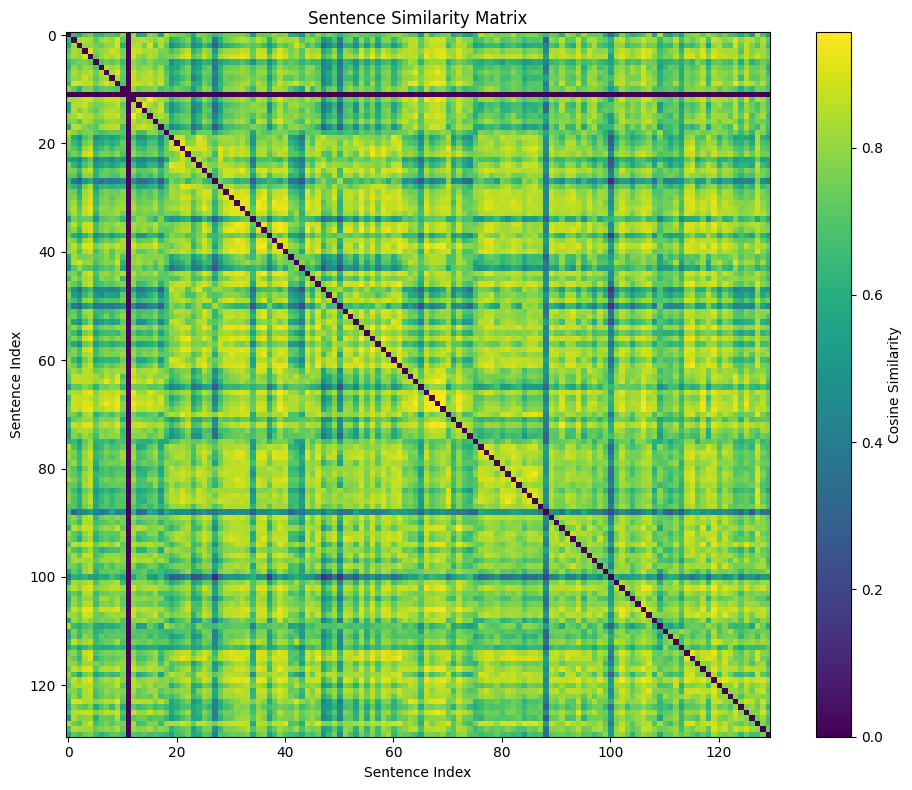

In [22]:
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="viridis")
plt.title("Sentence Similarity Matrix")
plt.xlabel("Sentence Index")
plt.ylabel("Sentence Index")
plt.colorbar(label="Cosine Similarity")
plt.tight_layout()
plt.show()

**Similarity Matrix Heatmap Interpretation**

The heatmap above represents the cosine similarity between all pairs of sentences in the dataset. Each cell (i, j) indicates how semantically similar sentence i is to sentence j, based on the average of their word embeddings.

**Color scale:**

- Dark purple ≈ low similarity (close to 0)
- Bright yellow ≈ high similarity (close to 1)

**Diagonal line:**

The dark diagonal line from top-left to bottom-right represents each sentence compared with itself, always yielding a similarity of 1. These values were set to 0 in the matrix for processing purposes but remain visually distinct.

**Patterns:**

- Brighter bands suggest groups of sentences that are semantically close (e.g., discussing similar tennis topics or players).
- Darker areas indicate sentences that are more unique in meaning compared to others.

This visualization helps to confirm that the similarity computation is capturing meaningful patterns in the data and provides insight into the internal structure of the text.

### Step 7: Graph Construction and Sentence Ranking

In [20]:
# Create a graph from the similarity matrix
similarity_graph = nx.from_numpy_array(similarity_matrix)

# Apply the PageRank algorithm to score each sentence
scores = nx.pagerank(similarity_graph)

# Convert the scores dictionary to a sorted list of sentence indices
ranked_sentences = sorted(((score, idx) for idx, score in scores.items()), reverse=True)

# Display the top 5 ranked sentence indices and their scores
print("Top 5 ranked sentences (score, index):")
for score, idx in ranked_sentences[:5]:
    print(f"{score:.4f} -> sentence #{idx}")

Top 5 ranked sentences (score, index):
0.0085 -> sentence #119
0.0085 -> sentence #39
0.0085 -> sentence #4
0.0084 -> sentence #32
0.0084 -> sentence #54


### Step 8: Generate Final Summary

In [23]:
# Choose the number of top-ranked sentences to include in the summary
num_sentences = 5

# Get the indices of the top-ranked sentences
top_sentence_indices = [idx for _, idx in ranked_sentences[:num_sentences]]

# Sort them in the original order of appearance (not by score)
top_sentence_indices.sort()

# Build the summary from the original sentences
summary = [sentences[idx] for idx in top_sentence_indices]

# Print the final summary
print("Generated Summary:")
for sent in summary:
    print("-", sent)

Generated Summary:
- So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match.
- Speaking at the Swiss Indoors tournament where he will play in Sundays final against Romanian qualifier Marius Copil, the world number three said that given the impossibly short time frame to make a decision, he opted out of any commitment.
- Major players feel that a big event in late November combined with one in January before the Australian Open will mean too much tennis and too little rest.
- Currently in ninth place, Nishikori with a win could move to within 125 points of the cut for the eight-man event in London next month.
- I was on a nice trajectorythen, Reid recalled.If I hadnt got sick, I think I could have started pushing towards the second week at the slams and then who knows. Duringa comeback attempt some five years later, Reid added Bernard Tomic and 2018 US Open Federer slayer John Millman to his

### Final Summary Interpretation

This project demonstrates a complete extractive text summarization pipeline using classical NLP techniques. Below is a recap and interpretation of the work completed:

#### Summary Pipeline Overview

We applied the following steps to build a summarization system:

1. **Data Loading and Cleaning**  
   - Articles were loaded from a CSV file and preprocessed to remove noise (punctuation, stop words, etc.).
  
2. **Sentence Tokenization**  
   - Articles were split into individual sentences for finer-grained analysis.

3. **Word Embedding with GloVe**  
   - Each word was represented using 100-dimensional GloVe vectors, allowing us to capture semantic meaning.

4. **Sentence Vectorization**  
   - Sentences were represented by averaging their word embeddings, producing fixed-size vector representations.

5. **Similarity Matrix Construction**  
   - Cosine similarity was used to compute pairwise similarity between all sentence vectors.

6. **Graph-based Ranking with PageRank**  
   - A graph was constructed from the similarity matrix, and PageRank was applied to score sentence importance.

7. **Summary Generation**  
   - The top-ranked sentences were extracted and reordered to produce the final summary.

#### Interpretation of the Final Summary

The top 5 ranked sentences covered diverse key points from the dataset:
- Competitive mindset of top athletes
- Tournament decisions and challenges
- Player qualification efforts
- Concerns about match scheduling and rest
- Reflections on career trajectories

This confirms the effectiveness of the similarity-based graph approach in identifying core ideas.

#### Reflection on the Approach

- **Strengths**:  
  The method is fully interpretable, unsupervised, and requires no training data. It works well with small to medium datasets.

- **Limitations**:  
  It relies on surface-level similarity and doesn’t capture deeper contextual meaning as well as transformer-based models.

#### Conclusion

This exercise provided hands-on experience with a classical NLP pipeline for extractive summarization. It demonstrates how traditional tools like GloVe, cosine similarity, and PageRank can be combined effectively to build an interpretable and functional summarization system.
